# regimes Exploration Notebook

Interactive exploration of the regimes package.

## Part 1: Setup and Data Generation

### 1.1 Imports and Version Check

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regimes as rg

print(f"regimes version: {sb.__version__}")

structbreak version: 0.1.0.dev0


### 1.2 Generate Sample Data for Regression Examples

Create a simple time series with a known break at observation 100. Before the break: intercept=1, slope=0.5. After: intercept=3, slope=1.5.

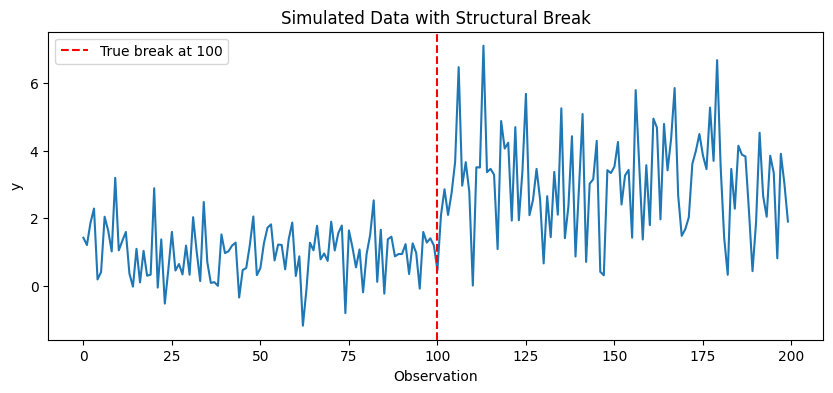

In [2]:
np.random.seed(42)
n = 200
break_point = 100

# Generate X (regressor)
X = np.random.randn(n)

# Generate y with different coefficients before/after break
y = np.zeros(n)
y[:break_point] = 1.0 + 0.5 * X[:break_point] + np.random.randn(break_point) * 0.5
y[break_point:] = 3.0 + 1.5 * X[break_point:] + np.random.randn(n - break_point) * 0.5

# Add constant to X for OLS
X_with_const = np.column_stack([np.ones(n), X])

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.axvline(x=break_point, color='r', linestyle='--', label=f'True break at {break_point}')
plt.xlabel('Observation')
plt.ylabel('y')
plt.title('Simulated Data with Structural Break')
plt.legend()
plt.show()

---
## Part 2: OLS Model with Breaks

### 2.1 OLS Without Breaks (Baseline)

Standard OLS ignoring the structural break. This pools all observations and provides a single set of parameter estimates.

In [3]:
ols_model = rg.OLS(y, X_with_const)
ols_results = ols_model.fit()
print(ols_results.summary())

                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               198
Cov. Type:       nonrobust   Df Model:                     2
R-squared:          0.4530   Adj. R-squared:          0.4503
Residual Std Err:   1.1757   Residual Variance:       1.3823
Log-Likelihood:    -315.16   AIC:                     634.31
F-statistic:        163.99   BIC:                     640.91
Prob (F-statistic): 1.11e-16
                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
             x0     2.0804     0.0832     25.001   0.00e+00      1.916      2.245
             x1     1.1464     0.0895     12.806   0.00e+00      0.970      1.323

                             Misspecification Tests                              
---------------------------------------------------

### 2.2 OLS With One Known Break

Specify a known break at t=100. The model estimates regime-specific parameters using dummy interactions.

In [4]:
ols_model_one_break = rg.OLS(y, X_with_const, breaks=[break_point])
ols_results_one_break = ols_model_one_break.fit()
print(ols_results_one_break.summary())

                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               196
Cov. Type:       nonrobust   Df Model:                     4
R-squared:          0.9053   Adj. R-squared:          0.9039
Residual Std Err:   0.4917   Residual Variance:       0.2417
Log-Likelihood:    -139.77   AIC:                     287.54
F-statistic:        624.68   BIC:                     300.73
Prob (F-statistic): 1.11e-16

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 100
  Regime 1: observations 0-99 (n=100)
  Regime 2: observations 100-199 (n=100)

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
     x0_re

### 2.3 OLS With Two Known Breaks

Multiple breaks can be specified. This creates three regimes with separate parameter estimates.

In [5]:
ols_model_two_breaks = rg.OLS(y, X_with_const, breaks=[100, 150])
ols_results_two_breaks = ols_model_two_breaks.fit()
print(ols_results_two_breaks.summary())

                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               194
Cov. Type:       nonrobust   Df Model:                     6
R-squared:          0.9056   Adj. R-squared:          0.9032
Residual Std Err:   0.4934   Residual Variance:       0.2435
Log-Likelihood:    -139.46   AIC:                     290.92
F-statistic:        372.27   BIC:                     310.71
Prob (F-statistic): 1.11e-16

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 100
Break at observation 150
  Regime 1: observations 0-99 (n=100)
  Regime 2: observations 100-149 (n=50)
  Regime 3: observations 150-199 (n=50)

                      coef    std err          t      P>|t|     [0.025     0.975]
----------------------------

### 2.4 OLS Fit by Regime

`fit_by_regime()` estimates separate OLS models for each regime, allowing completely independent specifications. Returns a list of OLSResults objects.

In [6]:
ols_model_full_break = rg.OLS(y, X_with_const, breaks=[break_point])
ols_results_full_break = ols_model_full_break.fit_by_regime()

print("Regime 1 (before break):")
print(ols_results_full_break[0].summary())
print("\nRegime 2 (after break):")
print(ols_results_full_break[1].summary())

Regime 1 (before break):
                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           100
Model:                 OLS   Df Residuals:                98
Cov. Type:       nonrobust   Df Model:                     2
R-squared:          0.5233   Adj. R-squared:          0.5184
Residual Std Err:   0.5349   Residual Variance:       0.2861
Log-Likelihood:     -78.31   AIC:                     160.63
F-statistic:        107.57   BIC:                     165.84
Prob (F-statistic): 1.11e-16
                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
             x0     1.0443     0.0538     19.396   0.00e+00      0.937      1.151
             x1     0.6139     0.0592     10.371   0.00e+00      0.496      0.731

                             Misspecification Tests                              
--------------------------

---
## Part 3: AR Model with Breaks

### 3.1 Generate AR Data with Intercept Shift

Simulate an AR(1) process with 200 observations where only the constant term shifts at t=100. True DGP: y_t = c_t + 0.7 * y_{t-1} + e_t, where c_t = 1.0 for t < 100, c_t = 3.0 for t >= 100.

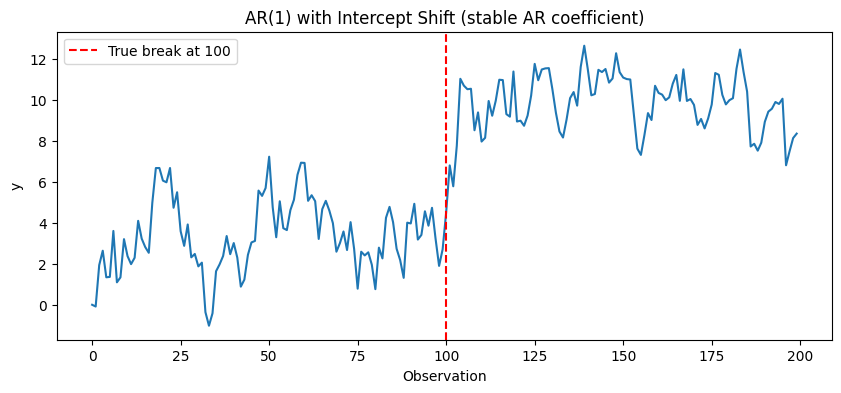

In [7]:
np.random.seed(123)
n_ar = 200
break_ar = 100
phi = 0.7  # AR coefficient (stable across regimes)

y_ar = np.zeros(n_ar)
for t in range(1, n_ar):
    c = 1.0 if t < break_ar else 3.0
    y_ar[t] = c + phi * y_ar[t-1] + np.random.randn()

# Plot the simulated series
plt.figure(figsize=(10, 4))
plt.plot(y_ar)
plt.axvline(x=break_ar, color='r', linestyle='--', label=f'True break at {break_ar}')
plt.xlabel('Observation')
plt.ylabel('y')
plt.title('AR(1) with Intercept Shift (stable AR coefficient)')
plt.legend()
plt.show()

### 3.2 AR Without Breaks (Baseline)

Standard AR(1) model ignoring the structural break.

In [8]:
ar_constant = rg.AR(y_ar, lags=1)
ar_results_constant = ar_constant.fit()
print(ar_results_constant.summary())

                                AR Model Results                                 
Dep. Variable:           y   No. Observations:           199
Model:               AR(1)   Df Residuals:               197
Cov. Type:       nonrobust   Df Model:                     2
R-squared:          0.8991   Adj. R-squared:          0.8986
Residual Std Err:   1.1463   Residual Variance:       1.3139
Log-Likelihood:    -308.53   AIC:                     621.06
                             BIC:                     627.64
                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
          const     0.4298     0.1682      2.555      0.011      0.098      0.762
           y.L1     0.9409     0.0225     41.900   0.00e+00      0.897      0.985
Roots are outside the unit circle (stationary).

                             Misspecification Tests                              
--------------------------------

### 3.3 AR With Common Breaks (All Coefficients Change)

Use `breaks=` to allow all parameters (constant and AR coefficients) to change at the break.

In [9]:
ar_common = rg.AR(y_ar, lags=1, breaks=[break_ar])
results_common = ar_common.fit()
print(results_common.summary())

                                AR Model Results                                 
Dep. Variable:           y   No. Observations:           199
Model:               AR(1)   Df Residuals:               195
Cov. Type:       nonrobust   Df Model:                     4
R-squared:          0.9140   Adj. R-squared:          0.9127
Residual Std Err:   1.0637   Residual Variance:       1.1315
Log-Likelihood:    -292.64   AIC:                     593.28
                             BIC:                     606.45

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 100
  Regime 1: observations 0-99 (n=100)
  Regime 2: observations 100-199 (n=100)

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
  const_regime1     0.8864     0.2295  

### 3.4 AR With Variable-Specific Breaks (Only Intercept Changes)

Use `variable_breaks=` to specify which parameters can change. Here only the constant shifts, while the AR coefficient is constrained to be the same across regimes.

In [10]:
ar_variable = rg.AR(y_ar, lags=1, variable_breaks={"const": [break_ar]})
results_variable = ar_variable.fit()
print(results_variable.summary())

                                AR Model Results                                 
Dep. Variable:           y   No. Observations:           199
Model:               AR(1)   Df Residuals:               196
Cov. Type:       nonrobust   Df Model:                     3
R-squared:          0.9138   Adj. R-squared:          0.9129
Residual Std Err:   1.0624   Residual Variance:       1.1286
Log-Likelihood:    -292.89   AIC:                     591.79
                             BIC:                     601.67

---------------------------------------------------------------------------------
Variable-Specific Structural Breaks
---------------------------------------------------------------------------------
const: break at observation 100
  Regime 1: obs 0-99, Regime 2: obs 100-199

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
  const_regime1     0.9842     0.1831      5.375 

### 3.5 AR Fit by Regime

Fit completely separate AR models for each regime. Returns a list of ARResults objects.

In [11]:
ar_regime = rg.AR(y_ar, lags=1, breaks=[break_ar])
results_by_regime = ar_regime.fit_by_regime()
print(rg.ar_summary_by_regime(results_by_regime, breaks=[break_ar], nobs_total=n_ar))

                           AR Model Results by Regime                            
Breaks at observations: 100

---------------------------------------------------------------------------------
                               Regime 1 (obs 0-99)                               
---------------------------------------------------------------------------------
Model:                 AR(1)   No. Observations:            99
Cov. Type:         nonrobust   Df Residuals:                97
R-squared:            0.5727   Adj. R-squared:          0.5683
Residual Std Err:     1.1422   Residual Variance:       1.3046
Log-Likelihood:      -152.63   AIC:                     309.26
                               BIC:                     314.45

Roots outside unit circle (stationary).

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
          const     0.8864     0.2465      3.596   5.10e-04

---
## Part 4: Bai-Perron Test — Different Usage Patterns

The Bai-Perron test detects unknown structural breaks. This section demonstrates three ways to create and use the test.

### 4.1 Direct Usage — Mean Shift Only

The simplest form: test for breaks in the mean only (constant term). Pass just `y` with no other arguments.

In [12]:
bp_mean_shift = rg.BaiPerronTest(y)
bp_results_mean = bp_mean_shift.fit()
print(f"Detected breaks: {bp_results_mean.break_indices}")
print(bp_results_mean.summary())

Detected breaks: [101]
                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          200
Trimming parameter:             0.15
Maximum breaks tested:             5
Breaking regressors (q):           1
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1      166.447        8.580       0.0000        Yes
    2       83.684        7.220       0.0000        Yes
    3       56.432        5.960       0.0000        Yes
    4       42.227        4.990       0.0000        Yes
    5       33.794        4.090       0.0000        Yes

UDmax statistic: 166.447 (5% critical: 8.880)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
    0  

### 4.2 Direct Usage — All Regressors Break

Use `exog_break=` to specify regressors whose coefficients can all change at breaks.

In [13]:
bp_all_break = rg.BaiPerronTest(y, exog_break=X_with_const)
bp_results_all = bp_all_break.fit()
print(f"Detected breaks: {bp_results_all.break_indices}")
print(bp_results_all.summary())

Detected breaks: [101]
                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          200
Trimming parameter:             0.15
Maximum breaks tested:             5
Breaking regressors (q):           2
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1      470.023       10.130       0.0000        Yes
    2      242.703        8.510       0.0000        Yes
    3      162.766        7.420       0.0000        Yes
    4      122.974        6.380       0.0000        Yes
    5       98.808        5.600       0.0000        Yes

UDmax statistic: 470.023 (5% critical: 10.550)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
    0 

### 4.3 Direct Usage — Mixed Breaking/Non-Breaking Regressors

Use `exog=` for regressors with stable coefficients and `exog_break=` for those that may change. Here all regressors are included but only the constant breaks.

In [14]:
bp_mixed = rg.BaiPerronTest(y, exog=X_with_const)  # exog_break defaults to constant
bp_results_mixed = bp_mixed.fit()
print(f"Detected breaks: {bp_results_mixed.break_indices}")
print(bp_results_mixed.summary())

Detected breaks: [35, 101]
                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          200
Trimming parameter:             0.15
Maximum breaks tested:             5
Breaking regressors (q):           1
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1      940.047        8.580       0.0000        Yes
    2      487.909        7.220       0.0000        Yes
    3      328.923        5.960       0.0000        Yes
    4      249.831        4.990       0.0000        Yes
    5      201.820        4.090       0.0000        Yes

UDmax statistic: 940.047 (5% critical: 8.880)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
   

### 4.4 From OLS Model — `BaiPerronTest.from_model()`

Create a Bai-Perron test directly from an existing OLS model. The `break_vars` parameter controls which coefficients can break.

In [15]:
# Create OLS model
model = rg.OLS(y, X_with_const, has_constant=False)

# Create Bai-Perron test from the model
bp_from_model = rg.BaiPerronTest.from_model(model, break_vars="all")
bp_results_from_model = bp_from_model.fit()
print(f"Detected breaks: {bp_results_from_model.break_indices}")

Detected breaks: [101]


### 4.5 OLS Convenience Method — `model.bai_perron()`

The most convenient way: call `.bai_perron()` directly on a model object. Combines model creation and test in one step.

In [16]:
# Create model and run Bai-Perron in one step
model = rg.OLS(y, X_with_const, has_constant=False)
bp_results = model.bai_perron(break_vars="all", max_breaks=5, selection="bic")
print(f"Detected breaks: {bp_results.break_indices}")

Detected breaks: [101]


### 4.6 Convert Results to OLS — `bp_results.to_ols()`

Convert Bai-Perron results back to an OLS model with the detected breaks incorporated.

In [17]:
# Convert to OLS with detected breaks
ols_with_detected_breaks = bp_results.to_ols(cov_type="HC1")
print(ols_with_detected_breaks.summary())

                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               196
Cov. Type:             HC1   Df Model:                     4
R-squared:          0.9056   Adj. R-squared:          0.9042
Residual Std Err:   0.4908   Residual Variance:       0.2409
Log-Likelihood:    -139.44   AIC:                     286.87
F-statistic:        626.99   BIC:                     300.07
Prob (F-statistic): 1.11e-16

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 101
  Regime 1: observations 0-100 (n=101)
  Regime 2: observations 101-199 (n=99)

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
     x0_re

### 4.7 Integrated Workflow (Model → Test → Model with Breaks)

Complete workflow: start with a constant-parameter model, test for breaks, incorporate them.

In [18]:
# Step 1: Define and fit model without breaks
model = rg.OLS(y, X_with_const, has_constant=False)
constant_results = model.fit()
print("Step 1: Constant parameter model")
print(f"  Params: {constant_results.params}")

# Step 2: Test for breaks
bp_results = model.bai_perron()
print(f"\nStep 2: Bai-Perron detected {bp_results.n_breaks} break(s) at: {bp_results.break_indices}")

# Step 3: Convert to OLS with breaks
ols_with_breaks = bp_results.to_ols()
print(f"\nStep 3: Model with breaks")
print(ols_with_breaks.summary())

Step 1: Constant parameter model
  Params: [2.08044041 1.14639184]



Step 2: Bai-Perron detected 1 break(s) at: [101]

Step 3: Model with breaks
                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               196
Cov. Type:       nonrobust   Df Model:                     4
R-squared:          0.9056   Adj. R-squared:          0.9042
Residual Std Err:   0.4908   Residual Variance:       0.2409
Log-Likelihood:    -139.44   AIC:                     286.87
F-statistic:        626.99   BIC:                     300.07
Prob (F-statistic): 1.11e-16

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 101
  Regime 1: observations 0-100 (n=101)
  Regime 2: observations 101-199 (n=99)

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------

---
## Part 5: Visualization

### 5.1 `plot_breaks()` — Basic Usage

Plot time series with vertical lines at break dates.

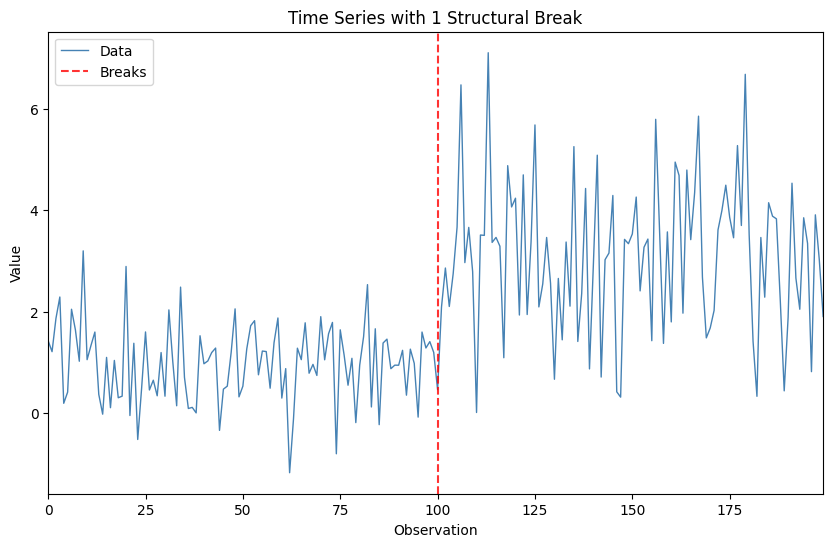

In [19]:
fig, ax = rg.plot_breaks(y, breaks=[100])
plt.show()

### 5.2 `plot_breaks()` — With `results` Parameter

Pass Bai-Perron results directly to extract breaks automatically.

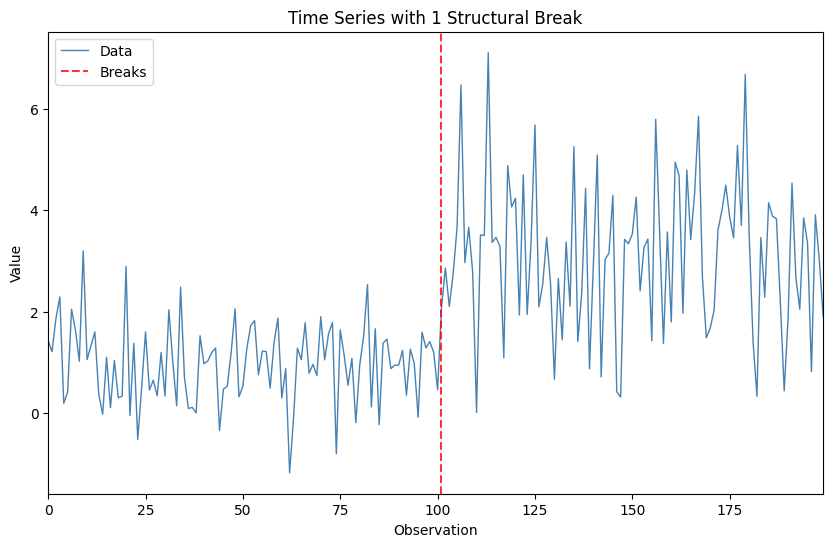

In [20]:
fig, ax = rg.plot_breaks(y, results=bp_results)
plt.show()

### 5.3 `plot_breaks()` — With Regime Shading

Set `shade_regimes=True` to color-code different regimes.

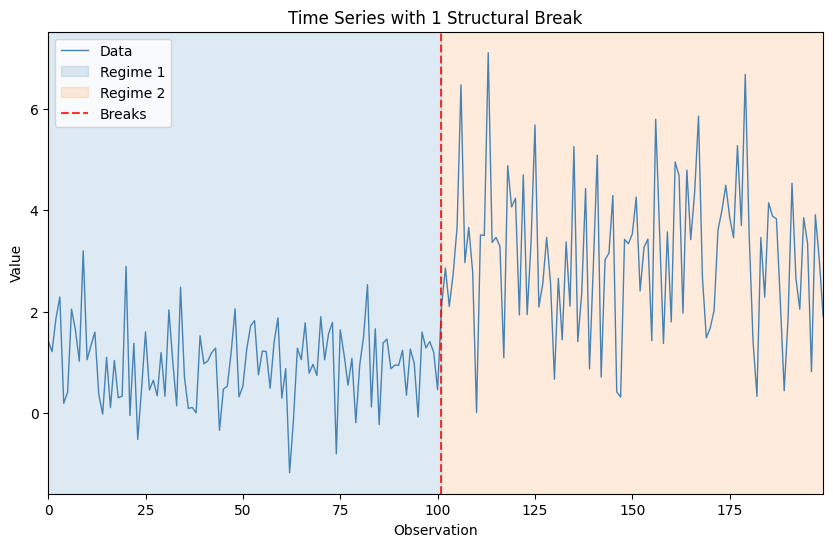

In [21]:
fig, ax = rg.plot_breaks(y, results=bp_results, shade_regimes=True)
plt.show()

### 5.4 `plot_regime_means()` — Regime Means Overlay

Plot the data with horizontal lines showing the mean in each regime.

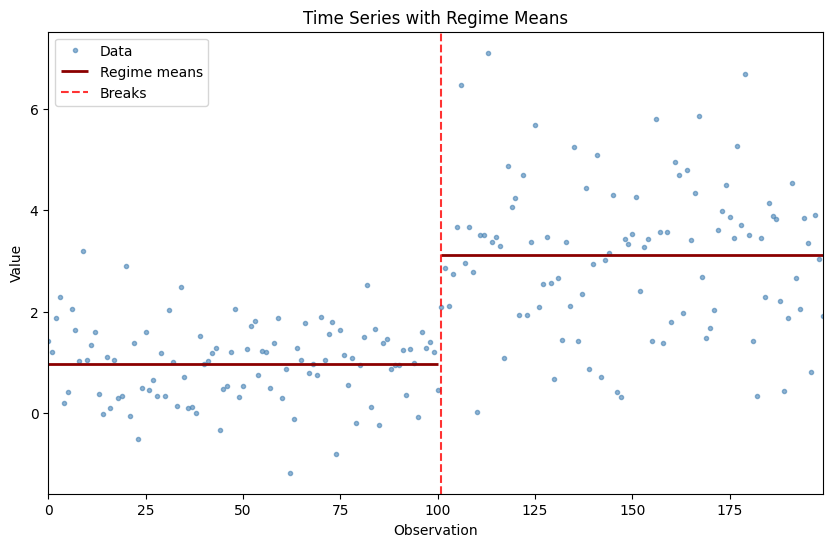

In [22]:
fig, ax = rg.plot_regime_means(y, breaks=bp_results.break_indices)
plt.show()

### 5.5 `plot_break_confidence()` — Confidence Intervals

Visualize uncertainty in break date estimation with confidence bands.

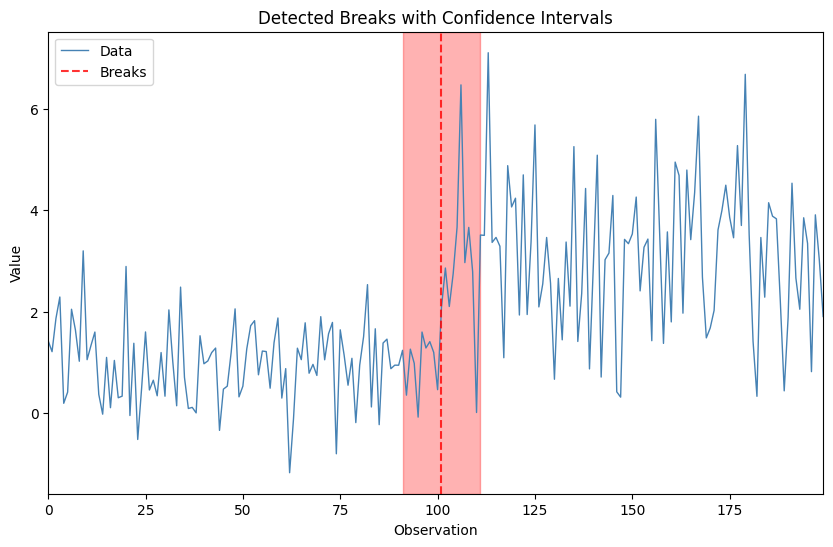

In [23]:
# Get confidence intervals from Bai-Perron results (or define manually)
confidence_intervals = [(b - 10, b + 10) for b in bp_results.break_indices]
fig, ax = rg.plot_break_confidence(
    y,
    breaks=bp_results.break_indices,
    confidence_intervals=confidence_intervals,
    title="Detected Breaks with Confidence Intervals"
)
plt.show()

### 5.6 `plot_params_over_time()` — Single Model

Visualize how parameter estimates change across regimes as step functions.

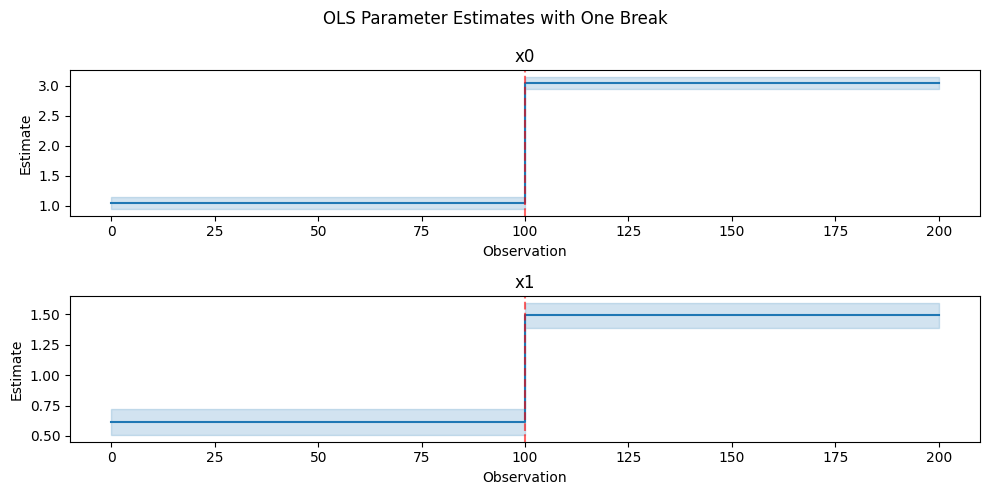

In [24]:
fig, axes = rg.plot_params_over_time(
    ols_results_one_break,
    figsize=(10, 5),
    title="OLS Parameter Estimates with One Break"
)
plt.tight_layout()
plt.show()

### 5.7 `plot_params_over_time()` — Comparing Multiple Models

Pass a dictionary of results to compare models with different break assumptions side by side.

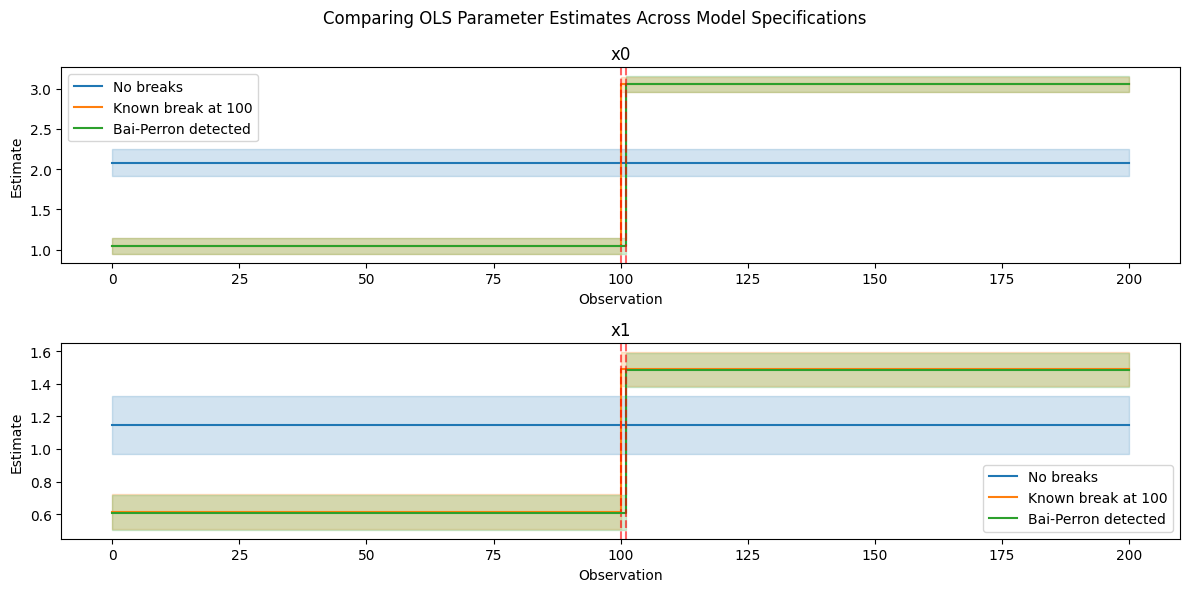

In [25]:
fig, axes = rg.plot_params_over_time(
    {
        "No breaks": ols_results,
        "Known break at 100": ols_results_one_break,
        "Bai-Perron detected": ols_with_breaks,
    },
    figsize=(12, 6),
    title="Comparing OLS Parameter Estimates Across Model Specifications"
)
plt.tight_layout()
plt.show()

### 5.8 `plot_diagnostics()` — PcGive-Style Misspecification Diagnostics

The `plot_diagnostics()` function creates a 2×2 panel of diagnostic plots mimicking OxMetrics/PcGive:
- **Actual vs Fitted**: Time series comparison
- **Residual Distribution**: Histogram with N(0,1) overlay
- **Scaled Residuals**: Vertical index plot (resid/σ) for spotting autocorrelation
- **ACF/PACF**: Autocorrelation and partial autocorrelation functions

In [ ]:
# Method access on results object
fig, axes = ols_results.plot_diagnostics()
plt.show()

### 5.9 Individual Diagnostic Plots

Each diagnostic component is also available as a standalone function for customization.

In [ ]:
# Individual diagnostic functions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Actual vs Fitted
sb.plot_actual_fitted(ols_results, ax=axes[0, 0])

# Residual Distribution
sb.plot_residual_distribution(ols_results, ax=axes[0, 1])

# Scaled Residuals
sb.plot_scaled_residuals(ols_results, ax=axes[1, 0])

# ACF/PACF needs its own subplots
axes[1, 1].remove()  # Remove the placeholder
fig_acf, ax_acf = rg.plot_residual_acf(ols_results, nlags=15)

plt.tight_layout()
plt.show()

### 5.10 Diagnostics for AR and ADL Models

Diagnostic plots work with all regression model types (OLS, AR, ADL).

In [ ]:
# Diagnostics for AR model
fig, axes = ar_results_constant.plot_diagnostics(nlags=15)
plt.show()

---
## Part 6: Rolling and Recursive Estimation

**Rolling estimation** uses a fixed-size window that moves through the sample. At each time point t, the model is estimated using observations from t - window + 1 to t.

**Recursive (expanding window) estimation** starts with a minimum number of observations and grows the sample by one observation at each step. At time t, the model uses all observations from 0 to t.

Both approaches allow tracking how parameter estimates evolve over time, which can reveal parameter instability and help identify structural breaks.

### 6.1 Rolling OLS — Direct Usage

Create a RollingOLS estimator directly with endog, exog, and window size.

In [26]:
# Direct usage: pass data and window size
rolling_direct = rg.RollingOLS(y, X_with_const, window=60)
rolling_results = rolling_direct.fit()
print(rolling_results.summary())

                    Rolling OLS Regression Results                    
No. Observations:               200
No. Parameters:                   2
Window Size:                     60
Valid Estimates:                141
Cov. Type:                nonrobust
----------------------------------------------------------------------
Parameter Summary (mean and std of estimates over time):
----------------------------------------------------------------------
                        mean          std          min          max
----------------------------------------------------------------------
             x0       2.0270       0.8667       0.9448       3.0568
             x1       1.0629       0.4089       0.4729       1.5459


### 6.2 Rolling OLS — From Model

Create rolling estimator from an existing OLS model using `.rolling()` method.

In [27]:
# From model: create OLS first, then call .rolling()
model = rg.OLS(y, X_with_const, has_constant=False)
rolling_from_model = model.rolling(window=60)
rolling_results_model = rolling_from_model.fit()
print(rolling_results_model.summary())

                    Rolling OLS Regression Results                    
No. Observations:               200
No. Parameters:                   2
Window Size:                     60
Valid Estimates:                141
Cov. Type:                nonrobust
----------------------------------------------------------------------
Parameter Summary (mean and std of estimates over time):
----------------------------------------------------------------------
                        mean          std          min          max
----------------------------------------------------------------------
             x0       2.0270       0.8667       0.9448       3.0568
             x1       1.0629       0.4089       0.4729       1.5459


### 6.3 Recursive OLS — Expanding Window

Recursive estimation uses an expanding window that starts with `min_nobs` observations and grows by one at each step.

In [28]:
# Recursive (expanding window) estimation
model = rg.OLS(y, X_with_const, has_constant=False)
recursive_results = model.recursive(min_nobs=30).fit()
print(recursive_results.summary())

                   Recursive OLS Regression Results                   
No. Observations:               200
No. Parameters:                   2
Min Observations:                30
Valid Estimates:                171
Cov. Type:                nonrobust
----------------------------------------------------------------------
Parameter Summary (mean and std of estimates over time):
----------------------------------------------------------------------
                        mean          std          min          max
----------------------------------------------------------------------
             x0       1.4373       0.3742       1.0280       2.0804
             x1       0.8389       0.1978       0.5867       1.1566


### 6.4 Visualize Rolling Coefficients

Plot coefficient estimates over time with confidence bands. The `plot_coefficients()` method shows how each parameter evolves.

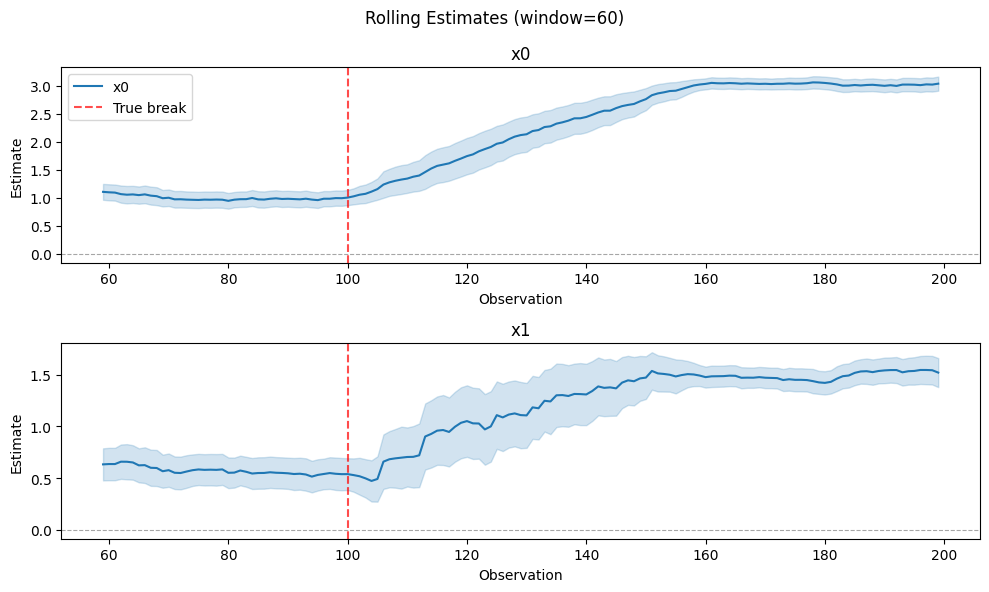

In [29]:
# Plot rolling coefficients with 95% confidence bands
fig, axes = rolling_results.plot_coefficients(figsize=(10, 6))

# Add vertical line at true break point
for ax in np.ravel(axes):
    ax.axvline(x=break_point, color='r', linestyle='--', alpha=0.7, label='True break')

np.ravel(axes)[0].legend()
plt.tight_layout()
plt.show()

### 6.5 Rolling AR — AR Model with Rolling Window

Rolling estimation also works with AR models using the `.rolling()` method.

In [30]:
# Rolling AR estimation
ar_model = rg.AR(y_ar, lags=1)
ar_rolling = ar_model.rolling(window=60)
ar_rolling_results = ar_rolling.fit()
print(ar_rolling_results.summary())

                        Rolling AR(1) Results                         
No. Observations:               199
No. Parameters:                   2
Lags:                    [1]
Window Size:                     60
Valid Estimates:                140
Cov. Type:                nonrobust
----------------------------------------------------------------------
Parameter Summary (mean and std of estimates over time):
----------------------------------------------------------------------
                        mean          std          min          max
----------------------------------------------------------------------
          const       1.5161       1.1460       0.4014       4.1778
           y.L1       0.7946       0.1004       0.5905       0.9481


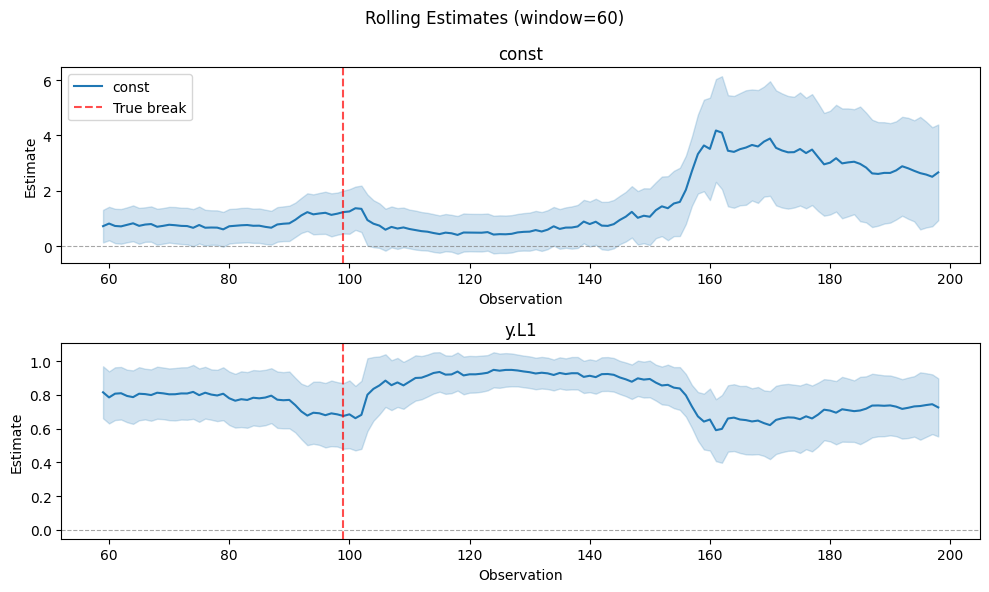

In [31]:
# Visualize rolling AR coefficients
fig, axes = ar_rolling_results.plot_coefficients(figsize=(10, 6))

# Add vertical line at true break point (adjusted for effective sample after lags)
for ax in np.ravel(axes):
    ax.axvline(x=break_ar - 1, color='r', linestyle='--', alpha=0.7, label='True break')

np.ravel(axes)[0].legend()
plt.tight_layout()
plt.show()

### 6.6 Compare Rolling vs Recursive Estimation

Both estimation approaches can be compared on the same plot to see how they differ.

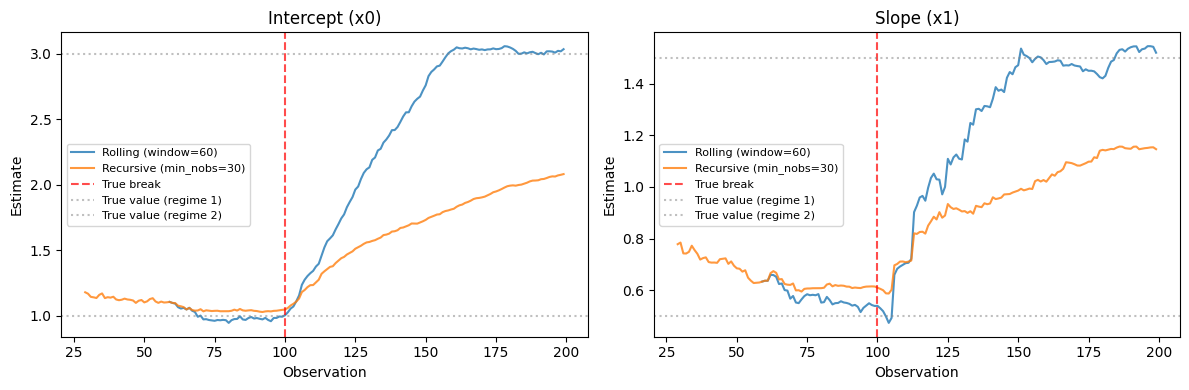

In [32]:
# Compare rolling vs recursive on the same axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot intercept (x0)
axes[0].plot(rolling_results.params[:, 0], label='Rolling (window=60)', alpha=0.8)
axes[0].plot(recursive_results.params[:, 0], label='Recursive (min_nobs=30)', alpha=0.8)
axes[0].axvline(x=break_point, color='r', linestyle='--', alpha=0.7, label='True break')
axes[0].axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='True value (regime 1)')
axes[0].axhline(y=3.0, color='gray', linestyle=':', alpha=0.5, label='True value (regime 2)')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Estimate')
axes[0].set_title('Intercept (x0)')
axes[0].legend(fontsize=8)

# Plot slope (x1)
axes[1].plot(rolling_results.params[:, 1], label='Rolling (window=60)', alpha=0.8)
axes[1].plot(recursive_results.params[:, 1], label='Recursive (min_nobs=30)', alpha=0.8)
axes[1].axvline(x=break_point, color='r', linestyle='--', alpha=0.7, label='True break')
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='True value (regime 1)')
axes[1].axhline(y=1.5, color='gray', linestyle=':', alpha=0.5, label='True value (regime 2)')
axes[1].set_xlabel('Observation')
axes[1].set_ylabel('Estimate')
axes[1].set_title('Slope (x1)')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

### 6.7 Complete Workflow: Model → Rolling → Bai-Perron → Model with Breaks

A typical workflow might combine rolling estimation (to visually identify instability) with formal break testing (Bai-Perron) and final estimation with detected breaks.

In [33]:
# Step 1: Define the base model
model = rg.OLS(y, X_with_const, has_constant=False)

# Step 2: Rolling estimation to visualize potential instability
rolling = model.rolling(window=60).fit()

# Step 3: Formal break test with Bai-Perron
bp_results = model.bai_perron(break_vars="all", max_breaks=3, selection="bic")

# Step 4: Estimate model with detected breaks
final_model = bp_results.to_ols()

print(f"Rolling estimation: {rolling.n_valid} valid windows")
print(f"Bai-Perron detected {bp_results.n_breaks} break(s) at: {bp_results.break_indices}")
print(f"\nFinal model with breaks:")
print(final_model.summary())

Rolling estimation: 141 valid windows
Bai-Perron detected 1 break(s) at: [101]

Final model with breaks:
                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               196
Cov. Type:       nonrobust   Df Model:                     4
R-squared:          0.9056   Adj. R-squared:          0.9042
Residual Std Err:   0.4908   Residual Variance:       0.2409
Log-Likelihood:    -139.44   AIC:                     286.87
F-statistic:        626.99   BIC:                     300.07
Prob (F-statistic): 1.11e-16

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 101
  Regime 1: observations 0-100 (n=101)
  Regime 2: observations 101-199 (n=99)

                      coef    std err          t      P>|t|     [0.02

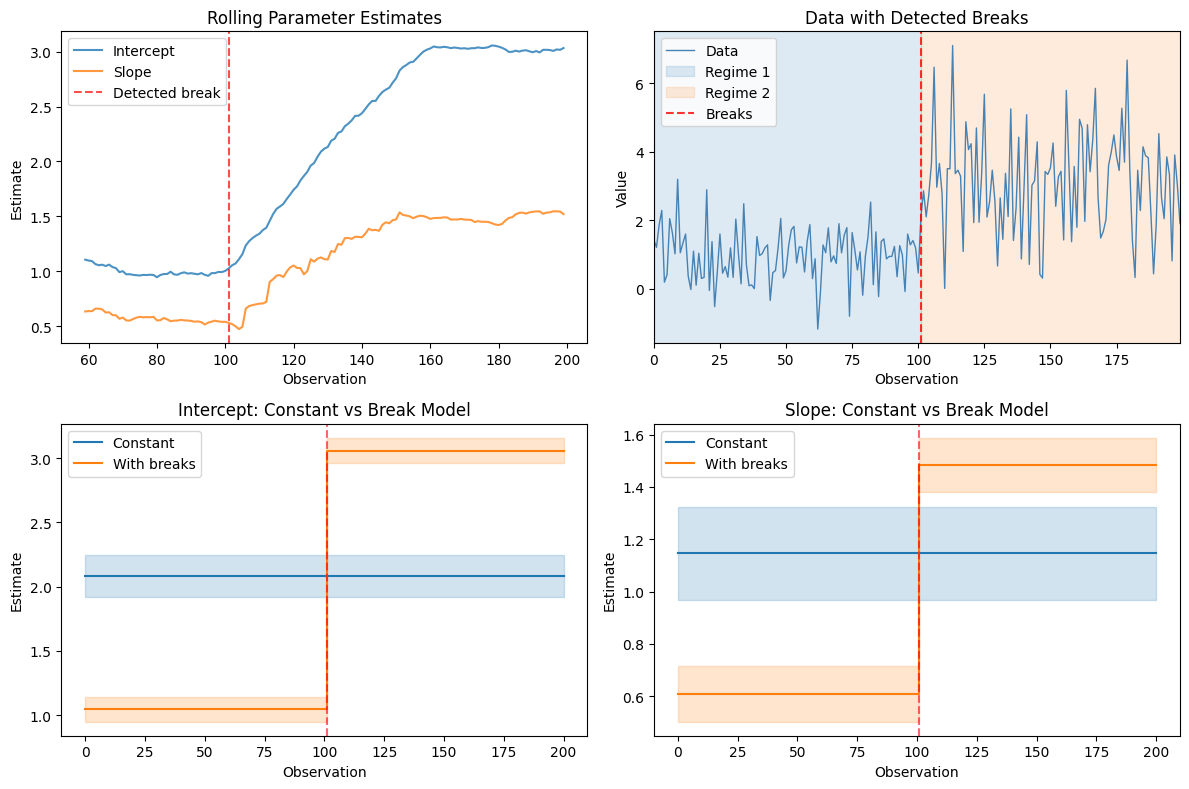

In [34]:
# Visualize the complete workflow
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top left: Rolling coefficient estimates
ax = axes[0, 0]
ax.plot(rolling.params[:, 0], label='Intercept', alpha=0.8)
ax.plot(rolling.params[:, 1], label='Slope', alpha=0.8)
ax.axvline(x=bp_results.break_indices[0], color='r', linestyle='--', alpha=0.7, label='Detected break')
ax.set_xlabel('Observation')
ax.set_ylabel('Estimate')
ax.set_title('Rolling Parameter Estimates')
ax.legend()

# Top right: Data with detected breaks
ax = axes[0, 1]
sb.plot_breaks(y, results=bp_results, shade_regimes=True, ax=ax)
ax.set_title('Data with Detected Breaks')

# Bottom left: Parameter comparison (intercept)
ax = axes[1, 0]
constant_results = model.fit()
sb.plot_params_over_time(
    {"Constant": constant_results, "With breaks": final_model},
    params=["x0"],
    ax=ax
)
ax.set_title('Intercept: Constant vs Break Model')

# Bottom right: Parameter comparison (slope)
ax = axes[1, 1]
sb.plot_params_over_time(
    {"Constant": constant_results, "With breaks": final_model},
    params=["x1"],
    ax=ax
)
ax.set_title('Slope: Constant vs Break Model')

plt.tight_layout()
plt.show()

---
## Part 7: ADL (Autoregressive Distributed Lag) Models

ADL models combine autoregressive dynamics (lagged dependent variable) with distributed lags on exogenous regressors. The general ADL(p,q) specification is:

$$y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{j=0}^{q} \beta_j x_{t-j} + \varepsilon_t$$

Key relationships:
- **AR(p) = ADL(p,0)**: AR is ADL with no distributed lags on exogenous variables
- **DL(q) = ADL(0,q)**: Distributed lag model is ADL with no autoregressive terms
- **OLS = ADL(0,0)**: Static regression is ADL with no lags at all

### 7.1 Generate ADL Sample Data

Simulate an ADL(1,1) process with known coefficients: y_t = 1.0 + 0.5*y_{t-1} + 0.3*x_t + 0.15*x_{t-1} + ε_t

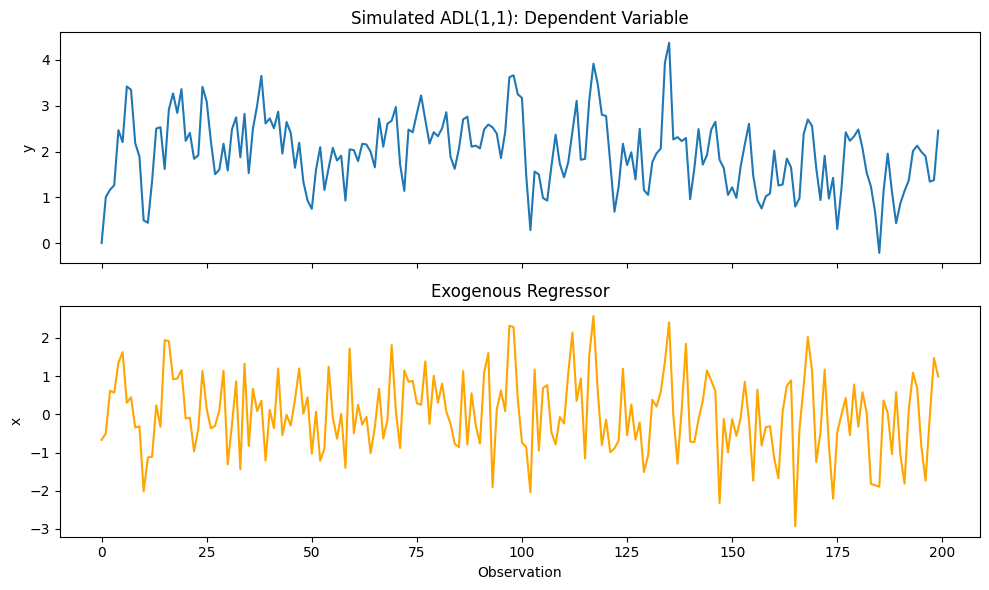

In [35]:
np.random.seed(456)
n_adl = 200

# Exogenous regressor
x_adl = np.random.randn(n_adl)

# True parameters
c_true = 1.0      # constant
phi_true = 0.5    # AR(1) coefficient
beta0_true = 0.3  # contemporaneous effect of x
beta1_true = 0.15 # lagged effect of x (L1)

# Simulate ADL(1,1) process
y_adl = np.zeros(n_adl)
for t in range(1, n_adl):
    y_adl[t] = c_true + phi_true * y_adl[t-1] + beta0_true * x_adl[t] + beta1_true * x_adl[t-1] + np.random.randn() * 0.5

# Plot the simulated series
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(y_adl)
axes[0].set_ylabel('y')
axes[0].set_title('Simulated ADL(1,1): Dependent Variable')

axes[1].plot(x_adl, color='orange')
axes[1].set_ylabel('x')
axes[1].set_xlabel('Observation')
axes[1].set_title('Exogenous Regressor')

plt.tight_layout()
plt.show()

### 7.2 Basic ADL Estimation

Fit an ADL(1,1) model — one AR lag and one distributed lag on x.

In [36]:
adl_model = rg.ADL(y_adl, x_adl, lags=1, exog_lags=1)
adl_results = adl_model.fit()
print(adl_results.summary())

print("\nTrue parameters:")
print(f"  const: {c_true}, phi: {phi_true}, beta0: {beta0_true}, beta1: {beta1_true}")

                                ADL Model Results                                
Dep. Variable:           y   No. Observations:           199
Model:            ADL(1,1)   Df Residuals:               195
Cov. Type:       nonrobust   Df Model:                     4
R-squared:          0.5740   Adj. R-squared:          0.5674
Residual Std Err:   0.5139   Residual Variance:       0.2641
Log-Likelihood:    -147.89   AIC:                     303.77
                             BIC:                     316.94
                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
          const     1.0792     0.1131      9.540   0.00e+00      0.856      1.302
           y.L1     0.4583     0.0541      8.474   5.77e-15      0.352      0.565
             x0     0.3460     0.0362      9.557   0.00e+00      0.275      0.417
          x0.L1     0.1061     0.0423      2.510      0.013      0.023      0.189

### 7.3 ADL with Multiple Exogenous Variables

When you have multiple exogenous regressors, you can specify:
- **Uniform lag structure**: `exog_lags=2` applies lags 0, 1, 2 to all variables
- **Variable-specific lags**: `exog_lags={"x0": 2, "x1": 0}` allows different lag structures per variable

In [37]:
# Generate a second exogenous variable
np.random.seed(789)
x1_adl = np.random.randn(n_adl)
X_multi = np.column_stack([x_adl, x1_adl])

# Uniform lag structure: 2 lags for all exog variables
adl_uniform = rg.ADL(y_adl, X_multi, lags=1, exog_lags=2)
results_uniform = adl_uniform.fit()
print("Uniform lag structure (exog_lags=2):")
print(f"Parameter names: {results_uniform.param_names}")
print()

# Variable-specific lag structure
adl_specific = rg.ADL(y_adl, X_multi, lags=1, exog_lags={"x0": 2, "x1": 0})
results_specific = adl_specific.fit()
print("Variable-specific lag structure (x0: 2 lags, x1: contemporaneous only):")
print(f"Parameter names: {results_specific.param_names}")

Uniform lag structure (exog_lags=2):
Parameter names: ['const', 'y.L1', 'x0', 'x0.L1', 'x0.L2', 'x1', 'x1.L1', 'x1.L2']

Variable-specific lag structure (x0: 2 lags, x1: contemporaneous only):
Parameter names: ['const', 'y.L1', 'x0', 'x0.L1', 'x0.L2', 'x1']


### 7.4 Distributed Lag Properties

ADL models provide two key measures of the dynamic effect of x on y:

- **Cumulative effect** (Σβ): Sum of distributed lag coefficients — the total effect of a one-unit change in x on y over all lags
- **Long-run multiplier** (Σβ / (1 - Σφ)): The equilibrium effect of a *permanent* unit change in x, accounting for autoregressive dynamics

In [38]:
# Distributed lag properties from the basic ADL(1,1) model
print("Distributed Lag Properties for ADL(1,1):")
print("-" * 50)
print(f"Cumulative effect:    {adl_results.cumulative_effect}")
print(f"Long-run multiplier:  {adl_results.long_run_multiplier}")

# Compute theoretical values from true parameters
true_cumulative = beta0_true + beta1_true
true_long_run = true_cumulative / (1 - phi_true)
print()
print(f"True cumulative effect:   {true_cumulative}")
print(f"True long-run multiplier: {true_long_run}")

Distributed Lag Properties for ADL(1,1):
--------------------------------------------------
Cumulative effect:    {'x0': 0.45209375264263707}
Long-run multiplier:  {'x0': 0.8346322131991551}

True cumulative effect:   0.44999999999999996
True long-run multiplier: 0.8999999999999999


### 7.5 Lag Selection

The `select_lags()` method performs a grid search over AR lags (p) and exog lags (q) to find the optimal specification using AIC or BIC.

In [39]:
# Create a model and use select_lags to find optimal specification
adl_base = rg.ADL(y_adl, x_adl, lags=1, exog_lags=0)

# Grid search using BIC (default)
optimal_p_bic, optimal_q_bic = adl_base.select_lags(max_ar_lags=4, max_exog_lags=4, criterion="bic")
print(f"Optimal using BIC: ADL({optimal_p_bic},{optimal_q_bic})")

# Grid search using AIC
optimal_p_aic, optimal_q_aic = adl_base.select_lags(max_ar_lags=4, max_exog_lags=4, criterion="aic")
print(f"Optimal using AIC: ADL({optimal_p_aic},{optimal_q_aic})")

print(f"\nTrue specification: ADL(1,1)")

Optimal using BIC: ADL(1,1)
Optimal using AIC: ADL(3,2)

True specification: ADL(1,1)


### 7.6 ADL with Structural Breaks

Generate ADL data with a break at observation 100, where the constant and AR coefficient change.

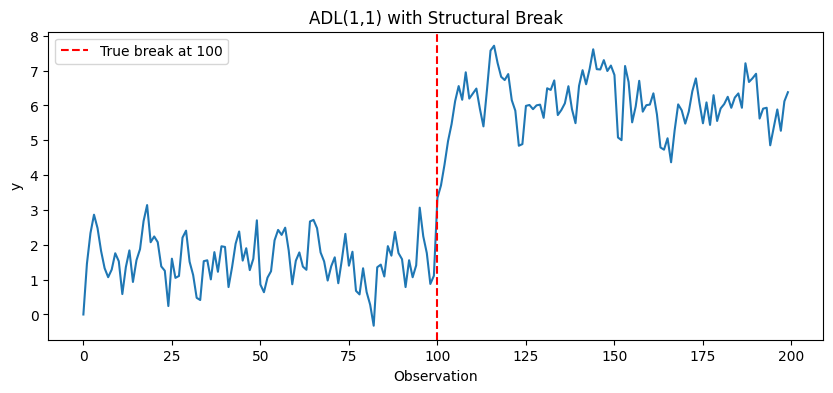

In [40]:
# Simulate ADL with a break at observation 100
np.random.seed(101)
n_adl_break = 200
break_adl = 100

x_adl_break = np.random.randn(n_adl_break)
y_adl_break = np.zeros(n_adl_break)

# Before break: c=1.0, phi=0.3
# After break: c=2.5, phi=0.6
for t in range(1, n_adl_break):
    if t < break_adl:
        c, phi = 1.0, 0.3
    else:
        c, phi = 2.5, 0.6
    y_adl_break[t] = c + phi * y_adl_break[t-1] + 0.3 * x_adl_break[t] + 0.15 * x_adl_break[t-1] + np.random.randn() * 0.5

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(y_adl_break)
plt.axvline(x=break_adl, color='r', linestyle='--', label=f'True break at {break_adl}')
plt.xlabel('Observation')
plt.ylabel('y')
plt.title('ADL(1,1) with Structural Break')
plt.legend()
plt.show()

In [41]:
# ADL with common breaks: all parameters can change at the break
adl_common_break = rg.ADL(y_adl_break, x_adl_break, lags=1, exog_lags=1, breaks=[break_adl])
results_common_break = adl_common_break.fit()
print("ADL with common breaks (all parameters change):")
print(results_common_break.summary())

ADL with common breaks (all parameters change):
                                ADL Model Results                                
Dep. Variable:           y   No. Observations:           199
Model:            ADL(1,1)   Df Residuals:               191
Cov. Type:       nonrobust   Df Model:                     8
R-squared:          0.9522   Adj. R-squared:          0.9504
Residual Std Err:   0.5279   Residual Variance:       0.2786
Log-Likelihood:    -151.14   AIC:                     318.28
                             BIC:                     344.62

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 100
  Regime 1: observations 0-99 (n=100)
  Regime 2: observations 100-199 (n=100)

                      coef    std err          t      P>|t|     [0.025     0.975]
-------------------------------------------------------------------------

In [42]:
# ADL with variable-specific breaks: only intercept changes
adl_variable_break = rg.ADL(y_adl_break, x_adl_break, lags=1, exog_lags=1, 
                            variable_breaks={"const": [break_adl]})
results_variable_break = adl_variable_break.fit()
print("ADL with variable-specific breaks (only constant changes):")
print(results_variable_break.summary())

ADL with variable-specific breaks (only constant changes):
                                ADL Model Results                                
Dep. Variable:           y   No. Observations:           199
Model:            ADL(1,1)   Df Residuals:               194
Cov. Type:       nonrobust   Df Model:                     5
R-squared:          0.9509   Adj. R-squared:          0.9499
Residual Std Err:   0.5307   Residual Variance:       0.2817
Log-Likelihood:    -153.76   AIC:                     317.53
                             BIC:                     333.99

---------------------------------------------------------------------------------
Variable-Specific Structural Breaks
---------------------------------------------------------------------------------
const: break at observation 100
  Regime 1: obs 0-99, Regime 2: obs 100-199

                      coef    std err          t      P>|t|     [0.025     0.975]
------------------------------------------------------------------------

### 7.7 Rolling and Recursive ADL

Rolling and recursive estimation help visualize parameter stability and can reveal potential structural breaks.

In [43]:
# Rolling ADL estimation
adl_model_break = rg.ADL(y_adl_break, x_adl_break, lags=1, exog_lags=1)
adl_rolling = adl_model_break.rolling(window=60)
adl_rolling_results = adl_rolling.fit()
print(adl_rolling_results.summary())

                       Rolling ADL(1,1) Results                       
No. Observations:               199
No. Parameters:                   4
AR Lags:                 [1]
  x0 Lags:            [0, 1]
Window Size:                     60
Valid Estimates:                140
Cov. Type:                nonrobust
----------------------------------------------------------------------
Parameter Summary (mean and std of estimates over time):
----------------------------------------------------------------------
                        mean          std          min          max
----------------------------------------------------------------------
          const       1.3291       1.0990       0.0973       3.2533
           y.L1       0.6179       0.2765       0.1839       0.9943
             x0       0.2054       0.0628       0.0620       0.3185
          x0.L1       0.0813       0.0884      -0.0755       0.2140


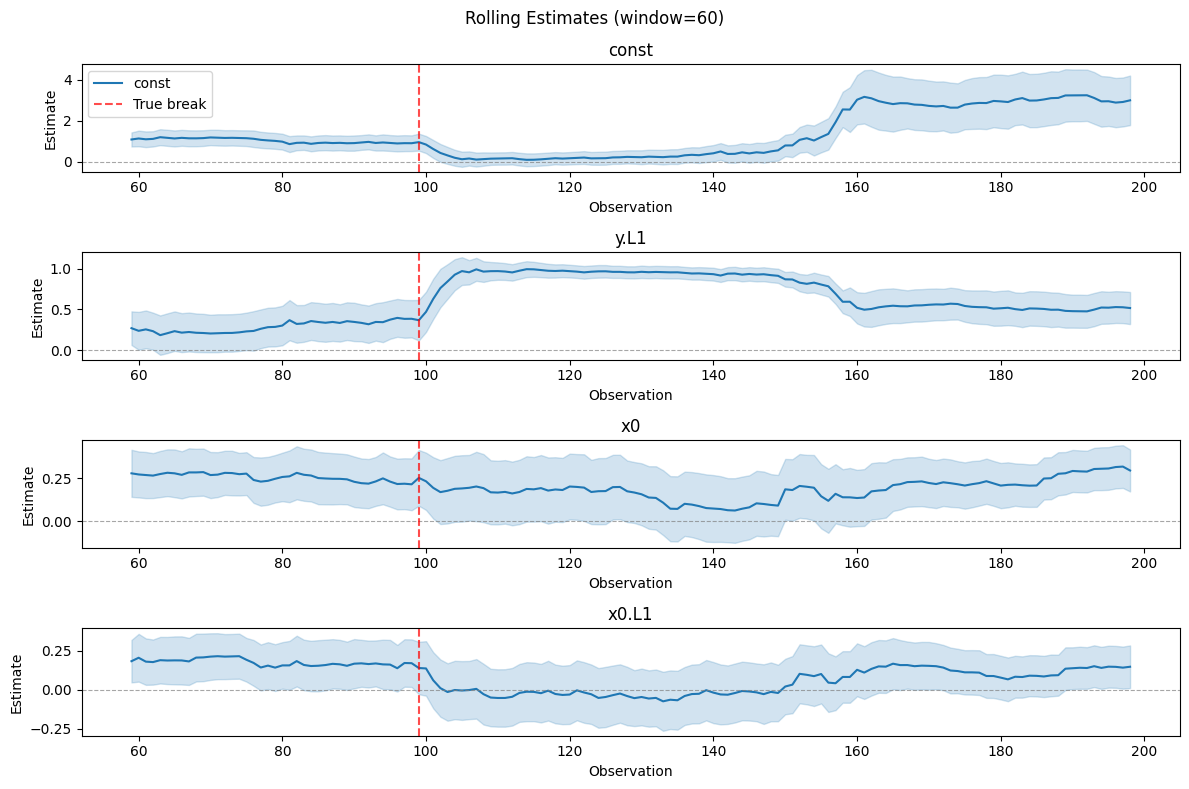

In [44]:
# Plot rolling coefficients
fig, axes = adl_rolling_results.plot_coefficients(figsize=(12, 8))

# Add vertical line at true break point (adjusted for effective sample)
for ax in np.ravel(axes):
    ax.axvline(x=break_adl - 1, color='r', linestyle='--', alpha=0.7, label='True break')

np.ravel(axes)[0].legend()
plt.tight_layout()
plt.show()

In [45]:
# Recursive ADL estimation
adl_recursive = adl_model_break.recursive(min_nobs=30)
adl_recursive_results = adl_recursive.fit()
print(adl_recursive_results.summary())

                      Recursive ADL(1,1) Results                      
No. Observations:               199
No. Parameters:                   4
AR Lags:                 [1]
  x0 Lags:            [0, 1]
Min Observations:                30
Valid Estimates:                170
Cov. Type:                nonrobust
----------------------------------------------------------------------
Parameter Summary (mean and std of estimates over time):
----------------------------------------------------------------------
                        mean          std          min          max
----------------------------------------------------------------------
          const       0.5473       0.4308       0.1469       1.1552
           y.L1       0.6676       0.3209       0.2232       0.9639
             x0       0.2275       0.0535       0.1540       0.3569
          x0.L1       0.0594       0.0799      -0.0219       0.1828


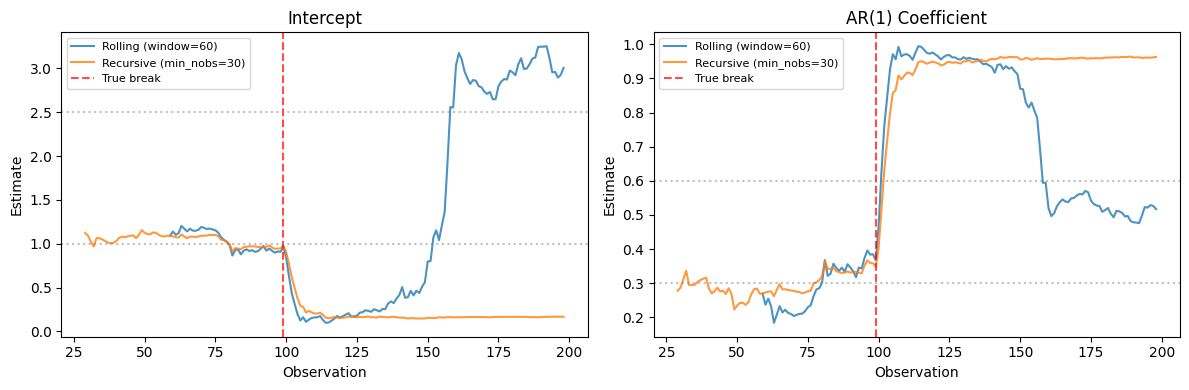

In [46]:
# Compare rolling vs recursive for key parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Intercept comparison
axes[0].plot(adl_rolling_results.params[:, 0], label='Rolling (window=60)', alpha=0.8)
axes[0].plot(adl_recursive_results.params[:, 0], label='Recursive (min_nobs=30)', alpha=0.8)
axes[0].axvline(x=break_adl - 1, color='r', linestyle='--', alpha=0.7, label='True break')
axes[0].axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
axes[0].axhline(y=2.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Estimate')
axes[0].set_title('Intercept')
axes[0].legend(fontsize=8)

# AR(1) coefficient comparison
axes[1].plot(adl_rolling_results.params[:, 1], label='Rolling (window=60)', alpha=0.8)
axes[1].plot(adl_recursive_results.params[:, 1], label='Recursive (min_nobs=30)', alpha=0.8)
axes[1].axvline(x=break_adl - 1, color='r', linestyle='--', alpha=0.7, label='True break')
axes[1].axhline(y=0.3, color='gray', linestyle=':', alpha=0.5)
axes[1].axhline(y=0.6, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Observation')
axes[1].set_ylabel('Estimate')
axes[1].set_title('AR(1) Coefficient')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

### 7.8 Bai-Perron Test for ADL

The `model.bai_perron()` method runs a formal structural break test on the ADL model.

In [47]:
# Run Bai-Perron test on ADL model
adl_test_model = rg.ADL(y_adl_break, x_adl_break, lags=1, exog_lags=1)
bp_adl_results = adl_test_model.bai_perron(break_vars="all", max_breaks=3, selection="bic")
print(f"Detected breaks: {bp_adl_results.break_indices}")
print(f"True break: {break_adl}")
print()
print(bp_adl_results.summary())

Detected breaks: [99]
True break: 100

                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          199
Trimming parameter:             0.15
Maximum breaks tested:             3
Breaking regressors (q):           4
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1       26.873       12.770       0.0000        Yes
    2       15.451       10.580       0.0000        Yes
    3       10.456        9.350       0.0000        Yes

UDmax statistic: 26.873 (5% critical: 12.810)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
    0     1       26.873       12.770        Yes
    1     2        2.938       10.580         No
    2

In [48]:
# Complete workflow: ADL → Bai-Perron → ADL with detected breaks
print("Complete ADL Workflow: Constant Model → Break Test → Model with Breaks")
print("=" * 70)

# Step 1: Fit ADL without breaks
adl_constant = rg.ADL(y_adl_break, x_adl_break, lags=1, exog_lags=1)
constant_result = adl_constant.fit()
print(f"\nStep 1: Constant ADL(1,1)")
print(f"  AIC: {constant_result.aic:.2f}, BIC: {constant_result.bic:.2f}")

# Step 2: Test for breaks
bp_result = adl_constant.bai_perron(break_vars="all", max_breaks=3)
print(f"\nStep 2: Bai-Perron Test")
print(f"  Detected {bp_result.n_breaks} break(s) at: {bp_result.break_indices}")

# Step 3: Fit ADL with detected breaks
if bp_result.break_indices:
    adl_with_breaks = rg.ADL(y_adl_break, x_adl_break, lags=1, exog_lags=1, 
                              breaks=bp_result.break_indices)
    break_result = adl_with_breaks.fit()
    print(f"\nStep 3: ADL with Detected Breaks")
    print(f"  AIC: {break_result.aic:.2f}, BIC: {break_result.bic:.2f}")
    print()
    print(break_result.summary())

Complete ADL Workflow: Constant Model → Break Test → Model with Breaks

Step 1: Constant ADL(1,1)
  AIC: 399.12, BIC: 412.30



Step 2: Bai-Perron Test
  Detected 1 break(s) at: [99]

Step 3: ADL with Detected Breaks
  AIC: 326.59, BIC: 352.94

                                ADL Model Results                                
Dep. Variable:           y   No. Observations:           199
Model:            ADL(1,1)   Df Residuals:               191
Cov. Type:       nonrobust   Df Model:                     8
R-squared:          0.9501   Adj. R-squared:          0.9483
Residual Std Err:   0.5390   Residual Variance:       0.2905
Log-Likelihood:    -155.30   AIC:                     326.59
                             BIC:                     352.94

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 99
  Regime 1: observations 0-98 (n=99)
  Regime 2: observations 99-199 (n=101)

                      coef    std err          t      P>|t|     [0.025     0.975]
------

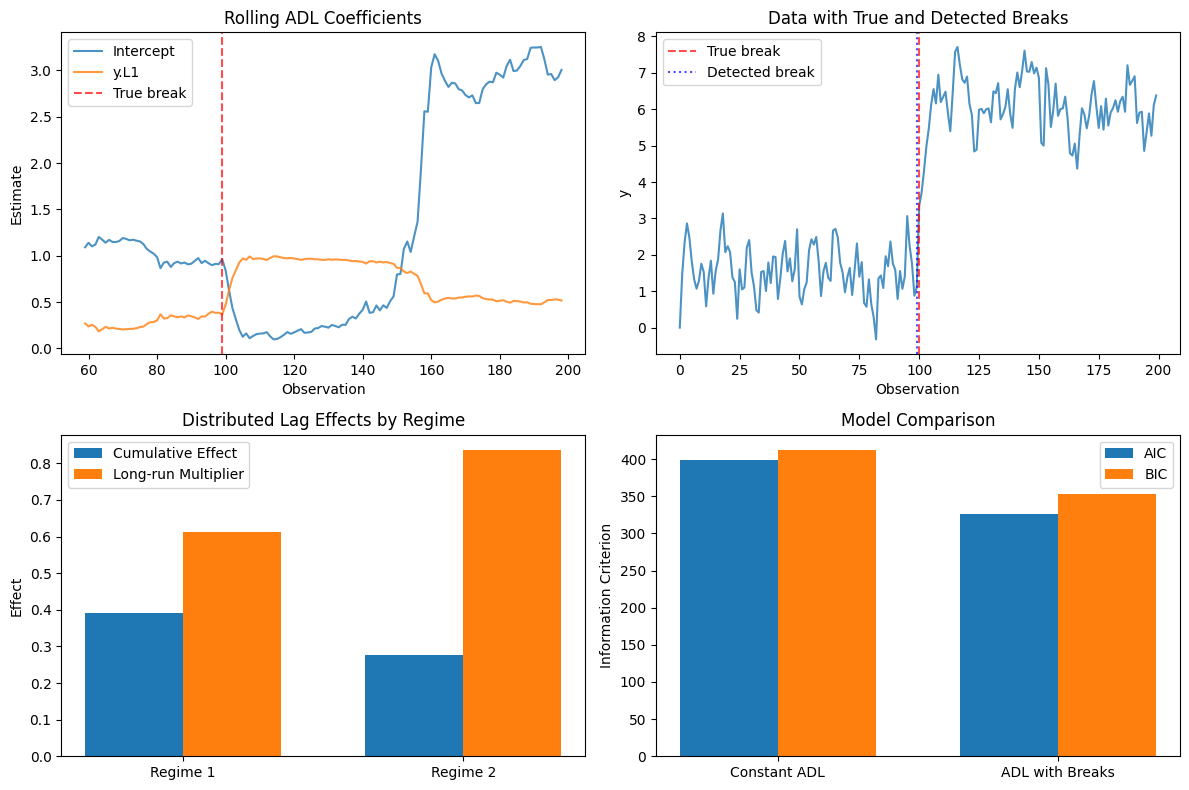

In [49]:
# Visualize the complete workflow
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top left: Rolling coefficients for intercept and AR(1)
ax = axes[0, 0]
ax.plot(adl_rolling_results.params[:, 0], label='Intercept', alpha=0.8)
ax.plot(adl_rolling_results.params[:, 1], label='y.L1', alpha=0.8)
ax.axvline(x=break_adl - 1, color='r', linestyle='--', alpha=0.7, label='True break')
ax.set_xlabel('Observation')
ax.set_ylabel('Estimate')
ax.set_title('Rolling ADL Coefficients')
ax.legend()

# Top right: Data with detected breaks
ax = axes[0, 1]
ax.plot(y_adl_break, alpha=0.8)
ax.axvline(x=break_adl, color='r', linestyle='--', alpha=0.7, label='True break')
for bp in bp_result.break_indices:
    ax.axvline(x=bp, color='blue', linestyle=':', alpha=0.7, label='Detected break')
ax.set_xlabel('Observation')
ax.set_ylabel('y')
ax.set_title('Data with True and Detected Breaks')
ax.legend()

# Bottom: Distributed lag effects by regime
ax = axes[1, 0]
if bp_result.break_indices:
    regimes = ["Regime 1", "Regime 2"]
    cum_effects = []
    lr_multipliers = []
    
    # Extract coefficients from the model with breaks
    params = break_result.params
    param_names = break_result.param_names
    
    # Find x0 and x0.L1 for each regime
    for r in [1, 2]:
        x0_idx = param_names.index(f"x0_regime{r}")
        x0l1_idx = param_names.index(f"x0.L1_regime{r}")
        yl1_idx = param_names.index(f"y.L1_regime{r}")
        
        cum = params[x0_idx] + params[x0l1_idx]
        lr = cum / (1 - params[yl1_idx])
        cum_effects.append(cum)
        lr_multipliers.append(lr)
    
    x = np.arange(len(regimes))
    width = 0.35
    ax.bar(x - width/2, cum_effects, width, label='Cumulative Effect')
    ax.bar(x + width/2, lr_multipliers, width, label='Long-run Multiplier')
    ax.set_xticks(x)
    ax.set_xticklabels(regimes)
    ax.set_ylabel('Effect')
    ax.set_title('Distributed Lag Effects by Regime')
    ax.legend()

# Bottom right: Model comparison via information criteria
ax = axes[1, 1]
models = ['Constant ADL', 'ADL with Breaks']
aics = [constant_result.aic, break_result.aic]
bics = [constant_result.bic, break_result.bic]
x = np.arange(len(models))
width = 0.35
ax.bar(x - width/2, aics, width, label='AIC')
ax.bar(x + width/2, bics, width, label='BIC')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Information Criterion')
ax.set_title('Model Comparison')
ax.legend()

plt.tight_layout()
plt.show()

## Part 8: Chow Test

The **Chow test** (Chow, 1960) tests whether regression coefficients change at a *known* break point. Unlike Bai-Perron, which searches for unknown breaks, the Chow test evaluates a specific hypothesis: "did a structural break occur at date *t*?"

This makes the two tests complementary:
- **Bai-Perron**: "Where are the breaks?" (exploratory)
- **Chow**: "Is there a break at this specific date?" (confirmatory)

The test comes in two variants:
- **Standard**: Both sub-samples have enough observations to estimate separate regressions
- **Predictive**: One sub-sample is too small; tests whether the larger model can predict the smaller sample

### 8.1 Direct Usage

Test for a break at the true break point (t=100) and at a wrong location (t=80):

In [ ]:
# Direct Chow test on y (uses constant-only model by default)
chow_test = rg.ChowTest(y)
chow_results = chow_test.fit(break_points=[100, 80])
print(chow_results.summary())

### 8.2 From an OLS Model

The `.chow_test()` convenience method works on OLS, AR, and ADL models:

In [ ]:
# Chow test via the OLS convenience method
model = rg.OLS(y, X_with_const, has_constant=False)
chow_from_model = model.chow_test(break_points=[100, 80])
print(chow_from_model.summary())

### 8.3 Comparing Chow and Bai-Perron

A natural workflow: use Bai-Perron to *find* breaks, then use Chow to *confirm* them at specific dates:

In [ ]:
# Step 1: Use Bai-Perron to find breaks
model = rg.OLS(y, X_with_const, has_constant=False)
bp_results = model.bai_perron()
print(f"Bai-Perron detected {bp_results.n_breaks} break(s) at: {bp_results.break_indices}")

# Step 2: Confirm detected breaks with Chow test
if bp_results.n_breaks > 0:
    chow_confirm = model.chow_test(break_points=list(bp_results.break_indices))
    print(f"\nChow test at Bai-Perron detected dates:")
    print(chow_confirm.summary())